In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt

import numpyro.distributions as dist

from empaf.jax_helpers import ln_simpson

# Make some fake data:

In [3]:
rng = np.random.default_rng(seed=8675309)  # obviously

K = 6  # number of Gaussians used to make fake data
M = 2  # dimensionality

true_m = rng.uniform(-1, 1, size=(K, M))

tmp = rng.uniform(-1, 1, size=(K, M, M))
true_C = 0.25 * np.einsum('kil,kjl->kij', tmp, tmp)

true_w = rng.uniform(0, 1, size=K)
true_w /= true_w.sum()

In [4]:
weights = dist.Categorical(probs=true_w)
components = dist.MultivariateNormal(loc=true_m, covariance_matrix=true_C)
mix = dist.MixtureSameFamily(weights, components)

In [5]:
samples = mix.sample(jax.random.PRNGKey(42), sample_shape=(100_000, ))

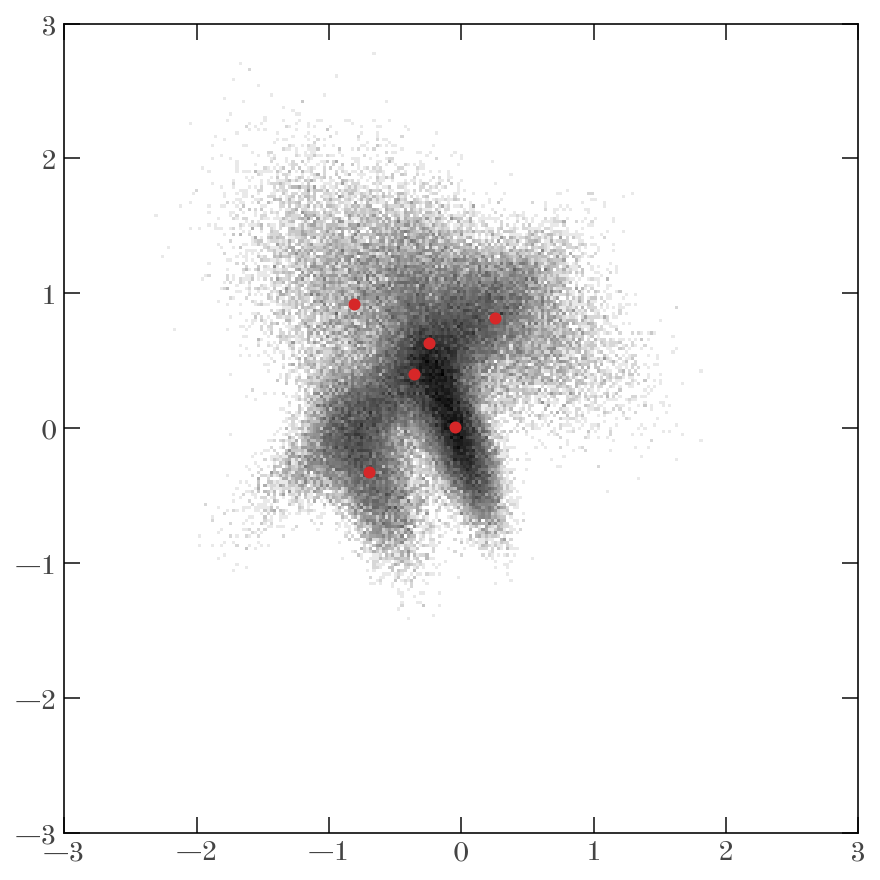

In [6]:
plt.hist2d(
    samples[:, 0],
    samples[:, 1],
    bins=np.linspace(-3, 3, 256),
    norm=mpl.colors.LogNorm(),
    cmap="Greys",
)
plt.scatter(true_m[:, 0], true_m[:, 1], color='tab:red')

# Censor the data with some complex selection:

In [7]:
_cen = (-0.1, 0.1)
_rad = 1.2
angs = np.linspace(np.pi / 2, 3 * np.pi / 2, 32)

censor_path = mpl.path.Path(
    np.stack((_rad * np.cos(angs) + _cen[0], _rad * np.sin(angs) + _cen[1])).T
)
mask = censor_path.contains_points(samples)
data = samples[mask]

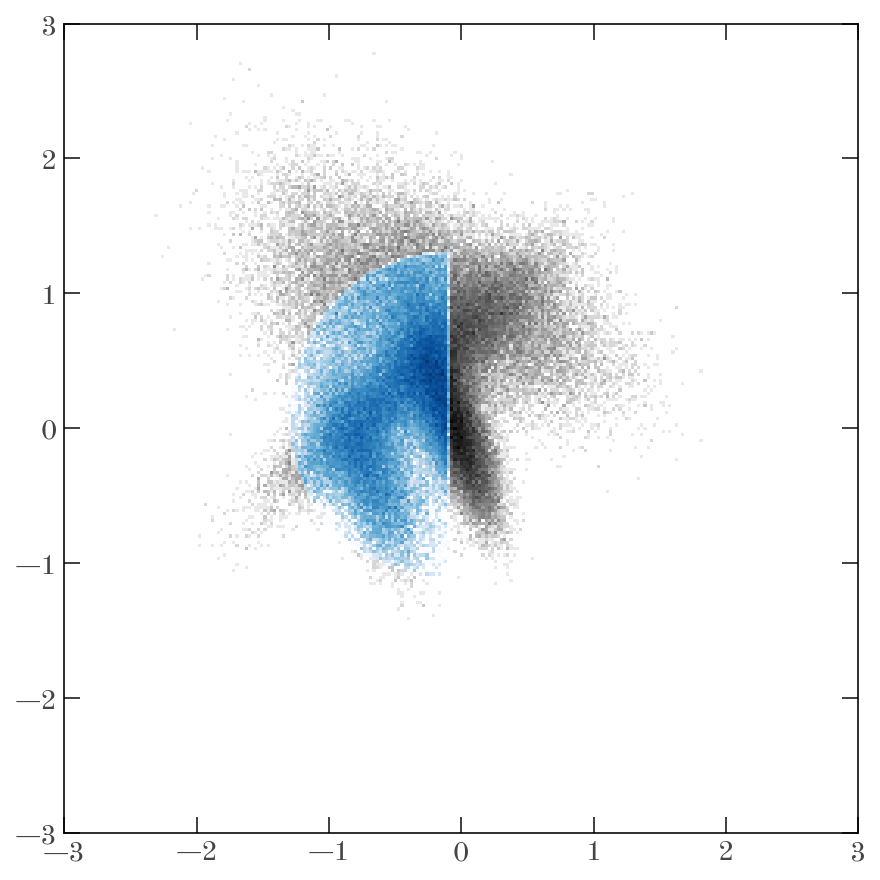

In [8]:
bins = np.linspace(-3, 3, 256)
plt.hist2d(
    samples[:, 0],
    samples[:, 1],
    bins=bins,
    norm=mpl.colors.LogNorm(),
    cmap="Greys",
)
plt.hist2d(
    data[:, 0],
    data[:, 1],
    bins=bins,
    norm=mpl.colors.LogNorm(),
    cmap="Blues",
);

# Now the Gaussian grid mixture model:

In [9]:
from scipy.stats import multivariate_normal
from jax.scipy.special import logsumexp
from functools import partial

In [107]:
class CensoredGridGMM:
    def __init__(self, locs, censor_path, bandwidth=1.0, ngrid=255):
        self.locs = np.array(locs)
        if not self.locs.ndim == 2:
            raise ValueError(
                "Input locs must be a 2D array with shape (K, M), where K is the number"
                " of components and M is the dimensionality"
            )
        self.K, self.M = self.locs.shape

        valid_shapes = [(), (self.K,), (self.K, self.M)]
        self.bandwidth = np.array(bandwidth)
        for shape in valid_shapes:
            if self.bandwidth.shape == shape:
                break
        else:
            raise ValueError(
                "The input bandwidth must be a scalar, or have a shape in: "
                f"{valid_shapes!r}"
            )

        # The bandwidth is assumed to have shape (K, M), which represents the isotropic
        # standard deviations of the Gaussian grid components along each dimension
        if self.bandwidth.shape != (self.K, self.M):
            self._bw = np.broadcast_to(self.bandwidth, (self.M, self.K)).T
        else:
            self._bw = self.bandwidth

        idx = np.arange(self.M)
        bw_cov = np.zeros((self.K, self.M, self.M))
        bw_cov[:, idx, idx] = self._bw[:, idx] ** 2
        self._bw_cov = bw_cov

        self._ln_prob_mass_fac = self._precompute_censored_mass(censor_path, ngrid)

        self._component_mask = np.isfinite(self._ln_prob_mass_fac)
        self._dist = dist.MultivariateNormal(
            loc=self.locs[self._component_mask],
            covariance_matrix=bw_cov[self._component_mask],
        )
        self._ln_prob_mass_fac = self._ln_prob_mass_fac[
            np.isfinite(self._ln_prob_mass_fac)
        ]
        
        self._stick = dist.transforms.StickBreakingTransform()

    def _precompute_censored_mass(self, censor_path, ngrid=251):
        """
        For each mixture component, compute the probability mass that is outside of the
        selection region using a Dumb Ass integration method.
        """
        grids_1d = [np.linspace(-1, 1, ngrid) for m in range(self.M)]
        grid_stacked = np.stack(np.meshgrid(*grids_1d))
        grid_flat = grid_stacked.reshape(self.M, -1).T

        # MAGIC NUMBER: number of sigma to integrate over
        NSIGMA = 6

        # MAGIC NUMBER: threshold to 0 out components in the grid
        THRESH = np.log(1e-2)

        ln_prob_mass_in_censor = np.full(self.K, -np.inf)
        for k, loc in enumerate(self.locs):
            sigma = NSIGMA * self._bw[k]
            this_grid = loc + sigma * grid_flat
            censor_check = censor_path.contains_points(this_grid)
            if censor_check.sum() == 0:
                continue

            ln_vol = np.sum(np.log(2 * sigma / (ngrid - 1)))

            # Here, some amount of this component exists within the censor region:
            mvn = multivariate_normal(mean=locs[k], cov=self._bw_cov[k])
            ln_vals = mvn.logpdf(this_grid[censor_check])
            ln_prob_mass_in_censor[k] = logsumexp(ln_vals + ln_vol)

        ln_prob_mass_in_censor[ln_prob_mass_in_censor < THRESH] = -np.inf

        return ln_prob_mass_in_censor

    def _eval(self, xs):
        xs = jnp.expand_dims(xs, -2)
        return self._dist.log_prob(xs)
    
    @partial(jax.jit, static_argnums=0)
    def log_prob(self, pars, data):
        ln_w = jnp.log(self._stick(pars['z']))
        component_ln_probs = self._eval(data) - self._ln_prob_mass_fac[None]
        return logsumexp(ln_w[None] + component_ln_probs, axis=1)

    @partial(jax.jit, static_argnums=0)
    def objective(self, pars, data):
        return -jnp.sum(self.log_prob(pars, data)) / len(data)

In [108]:
dx = 0.1
locs = np.stack(np.meshgrid(np.arange(-2, 1+1e-3, dx), np.arange(-2, 2+1e-3, dx)))
locs = locs.reshape(2, -1).T

In [110]:
gmm = CensoredGridGMM(locs, bandwidth=dx, censor_path=censor_path, ngrid=255)

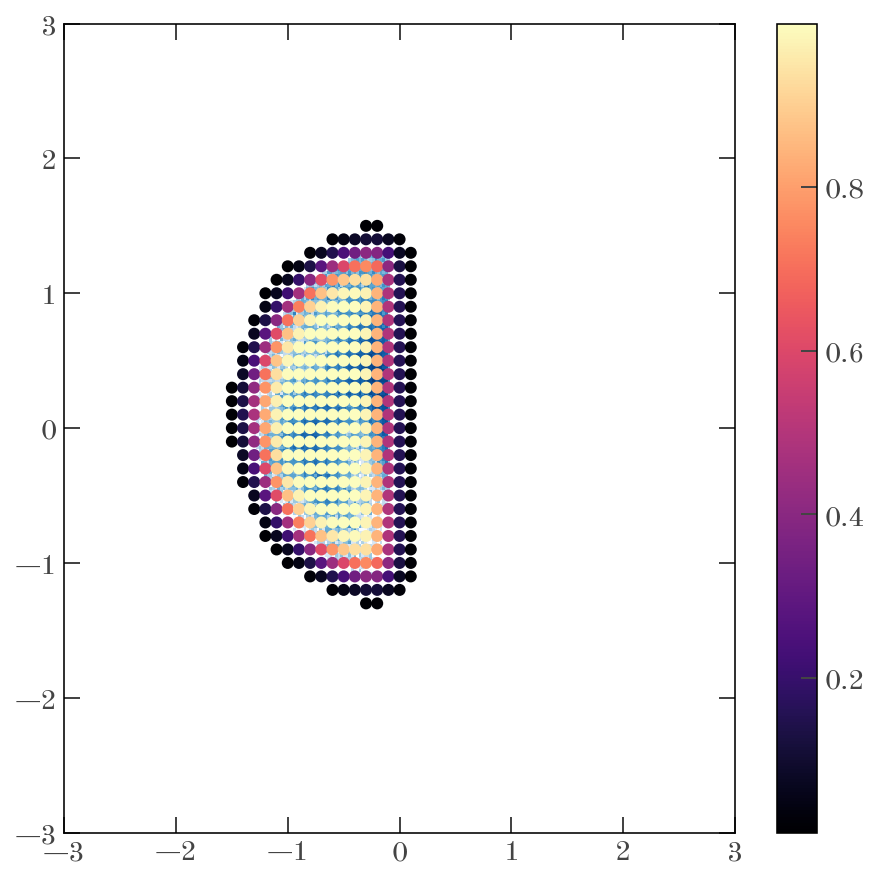

In [111]:
plt.hist2d(
    data[:, 0],
    data[:, 1],
    bins=bins,
    norm=mpl.colors.LogNorm(),
    cmap="Blues",
)
plt.scatter(
    locs[gmm._component_mask, 0],
    locs[gmm._component_mask, 1],
    c=np.exp(gmm._ln_prob_mass_fac),
)
plt.colorbar()

In [115]:
ncomps = gmm._component_mask.sum()
w = np.ones(ncomps) / ncomps
init_pars = {"z": stick.inv(w)}

In [116]:
opt = jaxopt.ScipyBoundedMinimize(
    method="L-BFGS-B", fun=lambda p, data: neg_ln_likelihood(p, data=data, gmm=gmm)
)
opt_res = opt.run(
    init_params=init_pars,
    data=data,
    bounds=({"z": np.full(ncomps - 1, -8)}, {"z": np.full(ncomps - 1, 8)}),
)

In [117]:
eval_grid = np.stack(np.meshgrid(bins, bins)).reshape(2, -1).T
opt_ln_probs = eval_ln_prob(opt_res.params, gmm, eval_grid).reshape(len(bins), len(bins))

eval_grid_mask = censor_path.contains_points(eval_grid).reshape(len(bins), len(bins))

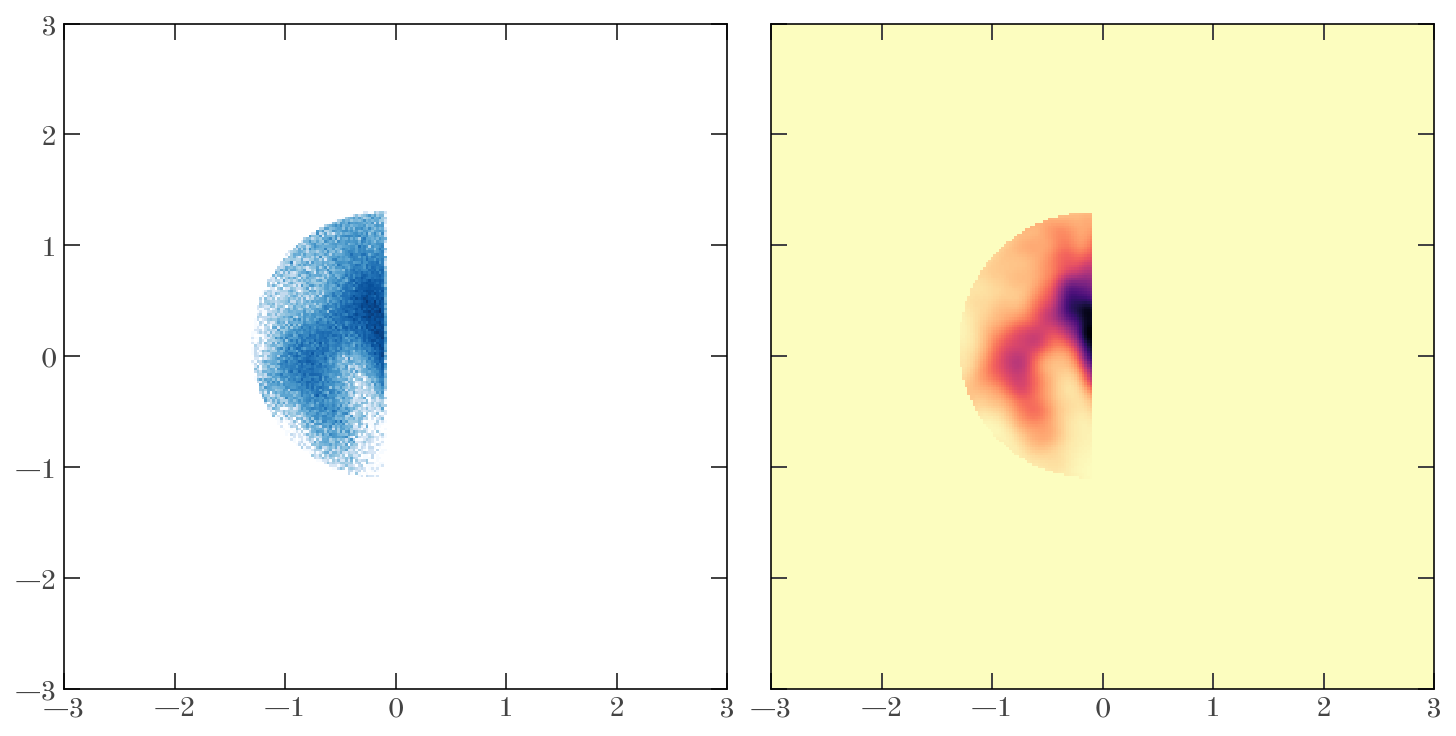

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
axes[0].hist2d(
    data[:, 0],
    data[:, 1],
    bins=bins,
    norm=mpl.colors.LogNorm(),
    cmap="Blues",
)

tmp = np.exp(opt_ln_probs)
tmp[~eval_grid_mask] = 0.
axes[1].pcolormesh(bins, bins, tmp, cmap='magma_r')